# Prática: Reconhecimento de Emoções a partir de Imagens da Webcam


## Importação de  bibliotecas

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

'4.11.0'

In [ ]:
#!pip install tensorflow==2.17.0
import tensorflow as tf
tf.__version__

'2.18.0'

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json

## Conexão com Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Criação do Dataset

In [ ]:
path = "/content/gdrive/MyDrive/Material.zip"
zip_object = zipfile.ZipFile(file = path, mode = "r")
zip_object.extractall('./')
zip_object.close()

In [ ]:
base_imgs = '/content/Material/fer2013.zip'
zip_object = zipfile.ZipFile(file = base_imgs, mode = "r")
zip_object.extractall('./')
zip_object.close()

In [ ]:
data = pd.read_csv('fer2013/fer2013.csv')
data.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [ ]:
pixels = data['pixels'].tolist()
pixels

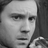

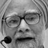

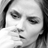

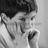

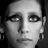

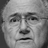

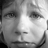

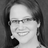

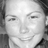

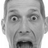

In [ ]:
largura, altura = 48, 48
faces = []
amostras = 0
for pixel_sequence in pixels:
  face = [int(pixel) for pixel in pixel_sequence.split(' ')]
  face = np.asarray(face).reshape(largura, altura)
  faces.append(face)

  if (amostras < 10):
    cv2_imshow(face)
  amostras += 1

In [ ]:
faces = np.asarray(faces)
faces = np.expand_dims(faces, -1)


In [ ]:
def normalizar(x):
  x = x.astype('float32')
  x = x / 255.0
  return x

In [ ]:
faces = normalizar(faces)

In [ ]:
emocoes = pd.get_dummies(data['emotion']).values

## Split Dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(faces, emocoes, test_size = 0.1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 41)

In [ ]:
print('Número de imagens no conjunto de treinamento:', len(X_train))
print('Número de imagens no conjunto de teste:', len(X_test))
print('Número de imagens no conjunto de validação:', len(X_val))

Número de imagens no conjunto de treinamento: 29068
Número de imagens no conjunto de teste: 3589
Número de imagens no conjunto de validação: 3230


In [ ]:
np.save('mod_xtest', X_test)
np.save('mod_ytest', y_test)

## Estrutura do modelo

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(width, height, 1), data_format = 'channels_last',
                 kernel_regularizer = l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation = 'softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 5, 5, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,905,863 (22.53 MB)

 Trainable params: 5,902,151 (22.51 MB)

 Non-trainable params: 3,712 (14.50 KB)

## Compilação do modelo

In [ ]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics = ['accuracy'])

arquivo_modelo = 'modelo_01_expressoes.h5'
arquivo_modelo_json = 'modelo_01_expressoes.json'

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor = 0.9, patience=3, verbose = 1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience = 8, verbose = 1, mode = 'auto')
checkpointer = ModelCheckpoint(arquivo_modelo, monitor='val_loss', verbose = 1, save_best_only=True)

In [ ]:
model_json = model.to_json()
with open(arquivo_modelo_json, 'w') as json_file:
  json_file.write(model_json)

## Treinamento

In [ ]:
history = model.fit(np.array(X_train), np.array(y_train),
                    batch_size = batch_size,
                    epochs = epochs,
                    verbose = 1,
                    validation_data = (np.array(X_val), np.array(y_val)),
                    shuffle=True,
                    callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.1974 - loss: 2.2774
Epoch 1: val_loss improved from inf to 1.82829, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 58s 77ms/step - accuracy: 0.1974 - loss: 2.2767 - val_accuracy: 0.2594 - val_loss: 1.8283 - learning_rate: 0.0010
Epoch 2/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2479 - loss: 1.8410
Epoch 2: val_loss improved from 1.82829 to 1.78965, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 53s 49ms/step - accuracy: 0.2479 - loss: 1.8410 - val_accuracy: 0.2594 - val_loss: 1.7897 - learning_rate: 0.0010
Epoch 3/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2508 - loss: 1.8184
Epoch 3: val_loss did not improve from 1.78965
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.2508 - loss: 1.8183 - val_accuracy: 0.2594 - val_loss: 1.8162 - learning_rate: 0.0010
Epoch 4/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2836 - loss: 1.7635
Epoch 4: val_loss improved from 1.78965 to 1.67976, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.2837 - loss: 1.7634 - val_accuracy: 0.3173 - val_loss: 1.6798 - learning_rate: 0.0010
Epoch 5/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3347 - loss: 1.6622
Epoch 5: val_loss improved from 1.67976 to 1.58065, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.3348 - loss: 1.6621 - val_accuracy: 0.3703 - val_loss: 1.5807 - learning_rate: 0.0010
Epoch 6/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3859 - loss: 1.5541
Epoch 6: val_loss improved from 1.58065 to 1.53055, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.3859 - loss: 1.5541 - val_accuracy: 0.3774 - val_loss: 1.5305 - learning_rate: 0.0010
Epoch 7/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4085 - loss: 1.4969
Epoch 7: val_loss improved from 1.53055 to 1.47033, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.4085 - loss: 1.4969 - val_accuracy: 0.4195 - val_loss: 1.4703 - learning_rate: 0.0010
Epoch 8/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4159 - loss: 1.4627
Epoch 8: val_loss improved from 1.47033 to 1.37668, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.4159 - loss: 1.4627 - val_accuracy: 0.4551 - val_loss: 1.3767 - learning_rate: 0.0010
Epoch 9/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4486 - loss: 1.4126
Epoch 9: val_loss did not improve from 1.37668
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.4486 - loss: 1.4125 - val_accuracy: 0.4483 - val_loss: 1.3917 - learning_rate: 0.0010
Epoch 10/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4699 - loss: 1.3717
Epoch 10: val_loss improved from 1.37668 to 1.31168, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.4700 - loss: 1.3716 - val_accuracy: 0.4839 - val_loss: 1.3117 - learning_rate: 0.0010
Epoch 11/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4965 - loss: 1.3260
Epoch 11: val_loss improved from 1.31168 to 1.25232, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.4965 - loss: 1.3260 - val_accuracy: 0.5310 - val_loss: 1.2523 - learning_rate: 0.0010
Epoch 12/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5136 - loss: 1.2953
Epoch 12: val_loss improved from 1.25232 to 1.24444, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.5136 - loss: 1.2953 - val_accuracy: 0.5399 - val_loss: 1.2444 - learning_rate: 0.0010
Epoch 13/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5177 - loss: 1.2768
Epoch 13: val_loss improved from 1.24444 to 1.18094, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.5177 - loss: 1.2768 - val_accuracy: 0.5533 - val_loss: 1.1809 - learning_rate: 0.0010
Epoch 14/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5357 - loss: 1.2332
Epoch 14: val_loss did not improve from 1.18094
455/455 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.5357 - loss: 1.2332 - val_accuracy: 0.5625 - val_loss: 1.1848 - learning_rate: 0.0010
Epoch 15/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5471 - loss: 1.2176
Epoch 15: val_loss improved from 1.18094 to 1.14855, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 23s 50ms/step - accuracy: 0.5471 - loss: 1.2177 - val_accuracy: 0.5628 - val_loss: 1.1486 - learning_rate: 0.0010
Epoch 16/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5498 - loss: 1.2104
Epoch 16: val_loss did not improve from 1.14855
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5498 - loss: 1.2104 - val_accuracy: 0.5421 - val_loss: 1.1996 - learning_rate: 0.0010
Epoch 17/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5688 - loss: 1.1699
Epoch 17: val_loss improved from 1.14855 to 1.12346, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.5688 - loss: 1.1699 - val_accuracy: 0.5827 - val_loss: 1.1235 - learning_rate: 0.0010
Epoch 18/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5733 - loss: 1.1474
Epoch 18: val_loss did not improve from 1.12346
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.5733 - loss: 1.1474 - val_accuracy: 0.5721 - val_loss: 1.1494 - learning_rate: 0.0010
Epoch 19/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5890 - loss: 1.1162
Epoch 19: val_loss did not improve from 1.12346
455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.5889 - loss: 1.1163 - val_accuracy: 0.5743 - val_loss: 1.1907 - learning_rate: 0.0010
Epoch 20/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5981 - loss: 1.0962
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0009000000427477062.

Epoch 20: val_loss did not improve from 1.12346
455/455 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.5981 - loss: 1.0962 - val

455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.6011 - loss: 1.0908 - val_accuracy: 0.5830 - val_loss: 1.1234 - learning_rate: 9.0000e-04
Epoch 22/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6168 - loss: 1.0473
Epoch 22: val_loss did not improve from 1.12335
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.6168 - loss: 1.0474 - val_accuracy: 0.5808 - val_loss: 1.1266 - learning_rate: 9.0000e-04
Epoch 23/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6188 - loss: 1.0284
Epoch 23: val_loss improved from 1.12335 to 1.05504, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.6188 - loss: 1.0284 - val_accuracy: 0.6158 - val_loss: 1.0550 - learning_rate: 9.0000e-04
Epoch 24/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6310 - loss: 1.0067
Epoch 24: val_loss did not improve from 1.05504
455/455 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.6310 - loss: 1.0067 - val_accuracy: 0.6093 - val_loss: 1.0835 - learning_rate: 9.0000e-04
Epoch 25/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6382 - loss: 1.0095
Epoch 25: val_loss did not improve from 1.05504
455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.6382 - loss: 1.0095 - val_accuracy: 0.6034 - val_loss: 1.0905 - learning_rate: 9.0000e-04
Epoch 26/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6510 - loss: 0.9664
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.

Epoch 26: val_loss did not improve from 1.05504
455/455 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.6510 - loss: 

455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.6529 - loss: 0.9533 - val_accuracy: 0.6266 - val_loss: 1.0448 - learning_rate: 8.1000e-04
Epoch 28/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6635 - loss: 0.9213
Epoch 28: val_loss did not improve from 1.04475
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.6635 - loss: 0.9213 - val_accuracy: 0.6176 - val_loss: 1.0565 - learning_rate: 8.1000e-04
Epoch 29/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6685 - loss: 0.9015
Epoch 29: val_loss improved from 1.04475 to 1.02558, saving model to modelo_01_expressoes.h5


455/455 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.6685 - loss: 0.9015 - val_accuracy: 0.6288 - val_loss: 1.0256 - learning_rate: 8.1000e-04
Epoch 30/100
454/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6832 - loss: 0.8737
Epoch 30: val_loss did not improve from 1.02558
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - accuracy: 0.6832 - loss: 0.8738 - val_accuracy: 0.6065 - val_loss: 1.0655 - learning_rate: 8.1000e-04
Epoch 31/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6785 - loss: 0.8854
Epoch 31: val_loss did not improve from 1.02558
455/455 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.6785 - loss: 0.8854 - val_accuracy: 0.6300 - val_loss: 1.0432 - learning_rate: 8.1000e-04
Epoch 32/100
455/455 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6965 - loss: 0.8435
Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.

Epoch 32: val_loss did not improve from 1.02558
455/455 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - accuracy: 0.6965 - loss: 

In [ ]:
print(history.history)

{'accuracy': [0.21790285408496857, 0.24948397278785706, 0.251616895198822, 0.2938626706600189, 0.3507981300354004, 0.39149579405784607, 0.4129627048969269, 0.42510664463043213, 0.4577542245388031, 0.4768129885196686, 0.49759185314178467, 0.5098389983177185, 0.52139812707901, 0.5335420370101929, 0.5420049428939819, 0.5567290782928467, 0.5648479461669922, 0.5748245716094971, 0.5805352926254272, 0.5924383997917175, 0.6035847067832947, 0.6153157949447632, 0.6211641430854797, 0.6292486786842346, 0.638881266117096, 0.6454520225524902, 0.6542589664459229, 0.6611393690109253, 0.6687422394752502, 0.6783060431480408, 0.6794413328170776, 0.6894867420196533, 0.6964015364646912, 0.7032819390296936, 0.7164923548698425, 0.7204486131668091, 0.7281202673912048], 'loss': [1.9760737419128418, 1.8357664346694946, 1.8120914697647095, 1.7380648851394653, 1.6310666799545288, 1.5409376621246338, 1.4890964031219482, 1.4504928588867188, 1.3999474048614502, 1.361718773841858, 1.3288459777832031, 1.30229055881500

## Testando o modelo

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)

var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
def tirar_foto(filename='photo.jpg', quality=2, size=(400,300)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

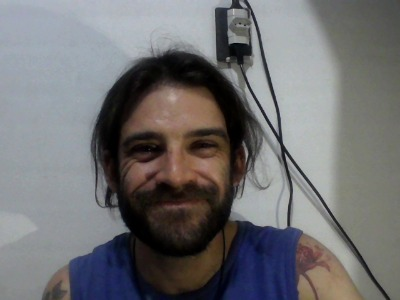

True

In [ ]:
# Clique na imagem da webcam para tirar uma foto
imagem = tirar_foto()
# Inverte a ordem dos canais (utilizar caso a imagem capturada fique com cores invertidas)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)
cv2_imshow(imagem)
cv2.imwrite("testecaptura.jpg",imagem)

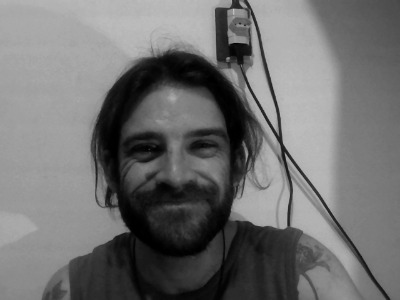

In [ ]:
original = imagem.copy()
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

In [ ]:
face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.1, 3)

In [ ]:
faces

array([[100,  90, 148, 148]], dtype=int32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


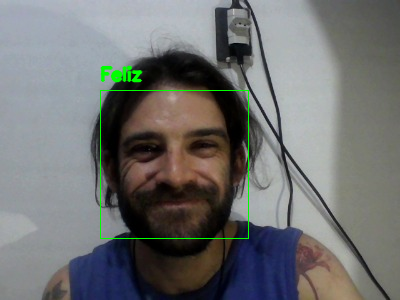

In [ ]:
for (x, y, w, h) in faces:
  cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi_gray = gray[y:y + h, x:x + w]
  roi_gray = roi_gray.astype('float') / 255.0
  cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
  prediction = loaded_model.predict(cropped_img)[0]
  cv2.putText(original, expressoes[int(np.argmax(prediction))], (x, y - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2, cv2.LINE_AA)

cv2_imshow(original)